<img src="./images/header.png">

***

# Exploiting Sentinel-1 SAR time series and artificial neural networks to detect grasslands in the northern Brazilian Amazon

[Part 3 - Classification]

Willian Vieira de Oliveira

<a id='Summary'></a>
### SUMMARY

1. [**Project Description**](./1_Project_Description.ipynb#About)
    1. [Primary objective](./1_Project_Description.ipynb#PrimaryObjetive)
    1. [Secondary objectives](./1_Project_Description.ipynb#SecondaryObjetives)
    
1. [**Study Site**](./1_Project_Description.ipynb#StudySite)

1. [**Sentinel-1 Data Description**](./1_Project_Description.ipynb#DataDescription)

1. [**Methodology Flowchart**](./1_Project_Description.ipynb#Methodology)
    1. [**MLP Architecture**](./1_Project_Description.ipynb#MLP)
    1. [**CNN Architecture**](./1_Project_Description.ipynb#CNN)
    1. [**LSTM Architecture**](./1_Project_Description.ipynb#LSTM)
    
1. [**Data preparation**](./2_Data_Preparation.ipynb)

1. [**Data classification**](#Summary)
    1. [**Classification of CR data**](./3_Classification_CR.ipynb)
    1. [**Classification of NL data**](./3_Classification_NL.ipynb)
    1. [**Classification of RGI data**](./3_Classification_RGI.ipynb)
    1. [**Classification of VH data**](./3_Classification_VH.ipynb)
    1. [**Classification of VV data**](#Summary)
    
1. [**Results**](./4_Results_and_Conclusion.ipynb#Results)

1. [**Conclusion**](./4_Results_and_Conclusion.ipynb#Conclusion)
***

## Import required packages

In [35]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

from osgeo import gdal

## Neural Network - MLP
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Neural Network - LSTM
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM, Conv1D
from keras.layers.merge import concatenate
from keras import utils#, optimizers

## Majority Filter operation
from scipy.ndimage.filters import generic_filter
from scipy.stats import mode

## Image visualization
import imageio

from sklearn.impute import SimpleImputer

***
## Input parameters

In [36]:
# Directory for a image data cube. 
# This file is used only to define basic parameters required for creating the ouput classifition map
imgPath = "DATA/VV_Cube.tif"

# Order of the dataframes listed below
filenames = ['VV', 'VH', 'CR', 'NL', 'RGI']

# Dataframes that describe the complete time series of ALL pixels, for each data cube
directories_pixel_TS = ["OUTPUT/TimeSeries_AllPixels_VV.csv", "OUTPUT/TimeSeries_AllPixels_VH.csv", 
                        "OUTPUT/TimeSeries_AllPixels_CR.csv", "OUTPUT/TimeSeries_AllPixels_NL.csv",
                        "OUTPUT/TimeSeries_AllPixels_RGI.csv"]

# Dataframes that describe the complete time series of SAMPLE pixels, for each data cube
directories_sample_TS = ["OUTPUT/TimeSeries_AllSamples_VV.csv", "OUTPUT/TimeSeries_AllSamples_VH.csv", 
                        "OUTPUT/TimeSeries_AllSamples_CR.csv", "OUTPUT/TimeSeries_AllSamples_NL.csv",
                        "OUTPUT/TimeSeries_AllSamples_RGI.csv"]

# Dataframes that describe the METRICS extracted from the time series of ALL pixels, for each data cube
directories_pixel_metrics = ["OUTPUT/Metrics_AllPixels_VV.csv", "OUTPUT/Metrics_AllPixels_VH.csv", 
                             "OUTPUT/Metrics_AllPixels_CR.csv", "OUTPUT/Metrics_AllPixels_NL.csv",
                             "OUTPUT/Metrics_AllPixels_RGI.csv"]

# Dataframes that describe the METRICS extracted from the time series of SAMPLE pixels, for each data cube
directories_sample_metrics = ["OUTPUT/Metrics_AllSamples_VV.csv", "OUTPUT/Metrics_AllSamples_VH.csv", 
                             "OUTPUT/Metrics_AllSamples_CR.csv", "OUTPUT/Metrics_AllSamples_NL.csv",
                             "OUTPUT/Metrics_AllSamples_RGI.csv"]

# Information regarding the classes of interest {0: Forest, 1: Grassland, 2: Agriculture}
labels = ['Forest', 'Grassland', 'Agriculture']
colours = ['darkgreen', 'palegreen', 'sandybrown'] # colours: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
n_classes = len(labels)

# Percentage of samples used for testing purposes.
test_size_ = 0.3

# Would you like to write the dataframes to CSV files and the classificatio products to GeoTIFF files? ['YES', 'NO']
#write_files = 'NO'
write_files = 'YES'

#### Output directory to the classification output files

In [37]:
dir_output_metrics = "OUTPUT/Classification_metrics/"
dir_output_pixels = "OUTPUT/Classification_pixels/"

***
## AUXILIARY FUNCTIONS

#### Convert the prediction array to matrix

In [38]:
def predictionArray_to_matrix(imgPath, class_pred):    
    # Identification of parameters required to create the classification map
    example_img = gdal.Open(imgPath)
    Nrows = example_img.RasterYSize
    Ncols = example_img.RasterXSize
    GeoTransform = example_img.GetGeoTransform()
    Projection = example_img.GetProjection()
    example_img = None

    # Reshaping the classification result
    classif_array = np.reshape(class_pred, (Nrows-6, Ncols-6))

    # In this study, we disconsidered the border pixels (3-pixel length). Therefore, we need to adjust 
    # the array to follow the same characteristics of the example image (GeoTranform and Projection)
    classif_array_adjusted = np.empty((Nrows, Ncols), np.float32)
    classif_array_adjusted[3:Nrows-3, 3:Ncols-3] = classif_array
    
    return classif_array_adjusted, Nrows, Ncols, GeoTransform, Projection

#### Show the classification map

In [39]:
def show_classification_map(classification_matrix, labels, colours):     
    
    #cmap = colors.ListedColormap(['darkgreen', 'palegreen', 'sandybrown'])
    cmap = colors.ListedColormap(colours)

    #classification_matrix = imageio.imread(filename_map)
    plt.figure(figsize = (20,10))
    img = plt.imshow(classification_matrix, cmap=cmap)

    values = np.unique(classification_matrix)

    #handles = [mpatches.Patch(color=colours[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
    handles = [mpatches.Patch(color=colours[i], label=labels[i]) for i in range(len(values))]
    plt.axis('off')
    plt.legend(handles=handles, ncol=len(labels), loc='lower center', fontsize=14, bbox_to_anchor=(0.5, -0.08))

    classification_matrix = None

#### Write a classification map to GeoTIFF file

In [40]:
def Write_GeoTiff(file, filename, Nrows, Ncols, geotransform, projection):
    driver = gdal.GetDriverByName('GTiff')
    
    dataset_output = driver.Create(filename, Ncols, Nrows, 1, gdal.GDT_Int32)#gdal.GDT_Float32)
    dataset_output.GetRasterBand(1).WriteArray(file)
    
    if geotransform is not None:
        gt = list(geotransform)
        dataset_output.SetGeoTransform(tuple(gt))
    dataset_output.SetProjection(projection)
    
    dataset_output = None

#### Export the classification results

In [41]:
def export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred):
    
    # Writing the classification product and the confusion matrix to files
    try:
        # Classification result (as array)
        pd.DataFrame(classification_matrix).to_csv(filename_array, index=False, header=False)

        # Classification map
        Write_GeoTiff(classification_matrix, filename_map, Nrows, Ncols, GeoTransform, Projection)

        # Confusion matrix
        confusion_pred.to_csv(filename_matrix, sep=',', index=True, header=True, index_label='Pred/Actual', 
                              encoding='utf-8-sig')
        print("    The products were written to file!")

    except Exception as e:
        print(str(e))

#### MLP Classification

In [42]:
def MLP_model(X_train, Y_train, X_test, Y_test, hidden_layer_sizes_, max_iter_, solver_, 
              learning_rate_init_, momentum_, alpha_):

    mlp = MLP(hidden_layer_sizes=(hidden_layer_sizes_), max_iter=max_iter_, solver=solver_, 
              learning_rate_init=learning_rate_init_, momentum=momentum_, alpha=alpha_)

    mlp.fit(X_train, Y_train)
    
    Y_train_pred = mlp.predict(X_train)
    acc_train = accuracy_score(Y_train, Y_train_pred) # Computes the accuracy
    print('    Overall accuracy (resubst): ' + str(round(acc_train,4)))
    
    Y_test_pred = mlp.predict(X_test)
    acc_test = accuracy_score(Y_test, Y_test_pred) # Computes the accuracy
    print('    Overall accuracy (holdout): ' + str(round(acc_test,4)))
    
     # confusion matrix for the testing dataset
    confusion_pred = pd.crosstab(Y_test_pred, Y_test, rownames=['Pred'], colnames=['Actual'], margins=False, margins_name="Total")
    confusion_pred.loc['Accuracies','OA_Resubs'] = acc_train
    confusion_pred.loc['Accuracies','OA_Holdout'] = acc_test

    return mlp, confusion_pred

#### LSTM Classification

https://keras.io/getting-started/sequential-model-guide/#specifying-the-input-shape

In this model, we stack 3 LSTM layers on top of each other, making the model capable of learning higher-level temporal representations. 

The first two LSTMs return their full output sequences, but the last one only returns the last step in its output sequence, thus dropping the temporal dimension (i.e. converting the input sequence into a single vector).

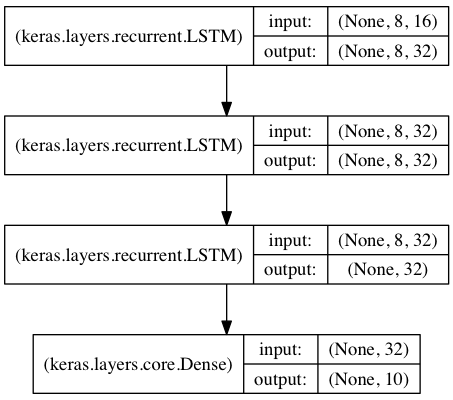

In [43]:
# https://keras.io/getting-started/sequential-model-guide/#specifying-the-input-shape
    
def LSTM_model(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, n_neurons=62, n_neurons_ouputLayer=3, 
                        training_epochs=50, batch_size=124, verbose=True):
    
    # Reshaping the data
    X_train_ = np.array(X_train.copy()).reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_ = np.array(X_test.copy()).reshape(X_test.shape[0], 1, X_test.shape[1])
    X_valid_ = np.array(X_valid.copy()).reshape(X_valid.shape[0], 1, X_valid.shape[1])

    Y_train_ = utils.to_categorical(Y_train)
    Y_test_ = utils.to_categorical(Y_test)
    Y_valid_ = utils.to_categorical(Y_valid)
    
    # design network
    lstm = Sequential()
    lstm.add(LSTM(n_neurons, return_sequences=True, input_shape=(1, X_train.shape[1])))
    lstm.add(LSTM(n_neurons, return_sequences=True))
    lstm.add(LSTM(n_neurons))
    lstm.add(Dense(n_neurons_ouputLayer, activation='softmax'))
    
    #lstm.compile(loss='mae', optimizer='adam')
    lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    #lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # fit network
    history = lstm.fit(X_train_, Y_train_, epochs=training_epochs, batch_size=batch_size,
                             validation_data=(X_valid_, Y_valid_), verbose=verbose, shuffle=False)
    #lstm.fit(X_train_, Y_train_, batch_size=62, epochs=5)
    
    lstm.summary()
    
    # plot history
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Evaluating the model
    Y_train_pred = lstm.predict_classes(X_train_)
    acc_train = accuracy_score(Y_train, Y_train_pred) # Computes the accuracy
    print('    Overall accuracy (resubst): ' + str(round(acc_train,4)))

    Y_test_pred = lstm.predict_classes(X_test_)
    acc_test = accuracy_score(Y_test, Y_test_pred) # Computes the accuracy
    print('    Overall accuracy (holdout): ' + str(round(acc_test,4)))

    # confusion matrix for the testing dataset
    confusion_pred = pd.crosstab(Y_test_pred, Y_test, rownames=['Pred'], colnames=['Actual'], margins=False, margins_name="Total")
    confusion_pred.loc['Accuracies','OA_Resubs'] = acc_train
    confusion_pred.loc['Accuracies','OA_Holdout'] = acc_test

    return lstm, confusion_pred

#### MLP using Keras

In [44]:
def model_MLP_keras(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, n_hidden_layers=3, n_neurons_ouputLayer=3, verbose=True, 
                    epochs=50, learning_rate=0.01, momentum=0.8):
    
    # Data reshaping
    X_train_ = np.array(X_train.copy()).reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_ = np.array(X_test.copy()).reshape(X_test.shape[0], 1, X_test.shape[1])
    X_valid_ = np.array(X_valid.copy()).reshape(X_valid.shape[0], 1, X_valid.shape[1])

    # Converting the target vectors to categorical data (required for loss='categorical_crossentropy')
    Y_train_ = utils.to_categorical(Y_train)
    Y_test_ = utils.to_categorical(Y_test)
    Y_valid_ = utils.to_categorical(Y_valid)
    
    # Network design
    MLP_keras = Sequential()
    MLP_keras.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
    MLP_keras.add(Dense(units=100, activation='relu'))
    MLP_keras.add(Dense(units=100))
    """
    for i in range(n_hidden_layers):
        MLP_keras.add(Dense(units=100, activation='relu'))
    """
    MLP_keras.add(Dense(units=n_neurons_ouputLayer, activation='softmax'))
    
    #MLP_keras.compile(optimizer='adam', loss='mse')
    MLP_keras.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    #sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=momentum)
    #MLP_keras.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    history = MLP_keras.fit(X_train, Y_train_, validation_data=(X_valid, Y_valid_), verbose=verbose, shuffle=False, epochs=epochs)
    
    MLP_keras.summary()
    
    ## plot history
    #plt.plot(history.history['loss'], label='Train')
    #plt.plot(history.history['val_loss'], label='Test')
    ##plt.title('Accuracy model')
    #plt.ylabel('Accuracy loss')
    #plt.xlabel('Epoch')
    #plt.legend()
    #plt.show()
    
    # Evaluating the model
    Y_train_pred = MLP_keras.predict_classes(X_train)
    acc_train = accuracy_score(Y_train, Y_train_pred) # Computes the accuracy
    print('    Overall accuracy (resubst): ' + str(round(acc_train,4)))

    Y_test_pred = MLP_keras.predict_classes(X_test)
    acc_test = accuracy_score(Y_test, Y_test_pred) # Computes the accuracy
    print('    Overall accuracy (holdout): ' + str(round(acc_test,4)))

    # confusion matrix for the testing dataset
    confusion_pred = pd.crosstab(Y_test_pred.flatten(), Y_test, rownames=['Pred'], colnames=['Actual'], margins=False, margins_name="Total")
    confusion_pred.loc['Accuracies','OA_Resubs'] = acc_train
    confusion_pred.loc['Accuracies','OA_Holdout'] = acc_test
    
    return MLP_keras, confusion_pred

#### LSTM and MLP ensemble

In [45]:
def model_LSTM_MLP(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, lstm, MLP_keras, n_classes=3, verbose=True, 
                   neurons=100, epochs=50):

    # Data reshaping
    X_train_ = np.array(X_train.copy()).reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_ = np.array(X_test.copy()).reshape(X_test.shape[0], 1, X_test.shape[1])
    X_valid_ = np.array(X_valid.copy()).reshape(X_valid.shape[0], 1, X_valid.shape[1])

    # Converting the target vectors to categorical data (required for loss='categorical_crossentropy')
    Y_train_ = utils.to_categorical(Y_train)
    Y_test_ = utils.to_categorical(Y_test)
    Y_valid_ = utils.to_categorical(Y_valid)

    combinedInput = concatenate([lstm.output, MLP_keras.output])

    x = Dense(units=neurons, activation="relu")(combinedInput)
    x = Dense(units=n_classes, activation="softmax")(x)

    lstm_mlp = Model(inputs=[lstm.input, MLP_keras.input], outputs=x)
    lstm_mlp.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    history = lstm_mlp.fit([X_train_, X_train], Y_train_, validation_data=([X_valid_,X_valid], Y_valid_), 
                           verbose=verbose, shuffle=False, epochs=epochs)

    lstm_mlp.summary()
    
    # Evaluating the model
    Y_train_pred = lstm_mlp.predict([X_train_, X_train])
    Y_train_pred = np.argmax(Y_train_pred, axis=1)
    acc_train = accuracy_score(Y_train, Y_train_pred) # Computes the accuracy
    print('    Overall accuracy (resubst): ' + str(round(acc_train,4)))

    Y_test_pred = lstm_mlp.predict([X_test_, X_test])
    Y_test_pred = np.argmax(Y_test_pred, axis=1)
    acc_test = accuracy_score(Y_test, Y_test_pred) # Computes the accuracy
    print('    Overall accuracy (holdout): ' + str(round(acc_test,4)))

    # confusion matrix for the testing dataset
    confusion_pred = pd.crosstab(Y_test_pred.flatten(), Y_test, rownames=['Pred'], colnames=['Actual'], margins=False, margins_name="Total")
    confusion_pred.loc['Accuracies','OA_Resubs'] = acc_train
    confusion_pred.loc['Accuracies','OA_Holdout'] = acc_test
    
    return lstm_mlp, confusion_pred

#### CNN

In [46]:
def model_CNN(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, kernel_size=3, filters=31, neurons=100,
              n_neurons_ouputLayer=3, verbose=True, epochs=50):

    # Data reshaping
    X_train_ = np.array(X_train.copy()).reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_ = np.array(X_test.copy()).reshape(X_test.shape[0], X_test.shape[1], 1)
    X_valid_ = np.array(X_valid.copy()).reshape(X_valid.shape[0], X_valid.shape[1], 1)

    # Converting the target vectors to categorical data (required for loss='categorical_crossentropy')
    Y_train_ = utils.to_categorical(Y_train)
    Y_test_ = utils.to_categorical(Y_test)
    Y_valid_ = utils.to_categorical(Y_valid)

    # Network design
    cnn = Sequential()
        # First convolutional layer
    cnn.add(Conv1D(filters, (kernel_size), input_shape=(X_train.shape[1],1), activation='relu'))
        # Second convolutional layer
    cnn.add(Conv1D(filters, (kernel_size), activation='relu'))
        # Flattening
    cnn.add(Flatten())
        # Hidden layer
    cnn.add(Dense(units=neurons, activation='softmax'))
        # Output layer
    cnn.add(Dense(units=n_neurons_ouputLayer, activation='softmax'))

    #cnn.compile(optimizer='adam', loss='mse')
    cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    #sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=momentum)
    #cnn.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    history = cnn.fit(X_train_, Y_train_, validation_data=(X_valid_, Y_valid_), verbose=verbose, shuffle=False, epochs=epochs)

    cnn.summary()

    # Evaluating the model
    Y_train_pred = cnn.predict_classes(X_train_)
    acc_train = accuracy_score(Y_train, Y_train_pred) # Computes the accuracy
    print('    Overall accuracy (resubst): ' + str(round(acc_train,4)))

    Y_test_pred = cnn.predict_classes(X_test_)
    acc_test = accuracy_score(Y_test, Y_test_pred) # Computes the accuracy
    print('    Overall accuracy (holdout): ' + str(round(acc_test,4)))

    # confusion matrix for the testing dataset
    confusion_pred = pd.crosstab(Y_test_pred.flatten(), Y_test, rownames=['Pred'], colnames=['Actual'], margins=False, margins_name="Total")
    confusion_pred.loc['Accuracies','OA_Resubs'] = acc_train
    confusion_pred.loc['Accuracies','OA_Holdout'] = acc_test
    
    return cnn, confusion_pred

#### LSTM and CNN ensemble

In [47]:
def model_LSTM_CNN(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, lstm, cnn, n_classes=3, verbose=True,
                   epochs=50, neurons=100):

    # Data reshaping
    X_train_ = np.array(X_train.copy()).reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_ = np.array(X_test.copy()).reshape(X_test.shape[0], 1, X_test.shape[1])
    X_valid_ = np.array(X_valid.copy()).reshape(X_valid.shape[0], 1, X_valid.shape[1])

    # Data reshaping
    X_train_cnn = np.array(X_train.copy()).reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = np.array(X_test.copy()).reshape(X_test.shape[0], X_test.shape[1], 1)
    X_valid_cnn = np.array(X_valid.copy()).reshape(X_valid.shape[0], X_valid.shape[1], 1)
    
    # Converting the target vectors to categorical data (required for loss='categorical_crossentropy')
    Y_train_ = utils.to_categorical(Y_train)
    Y_test_ = utils.to_categorical(Y_test)
    Y_valid_ = utils.to_categorical(Y_valid)

    combinedInput = concatenate([lstm.output, cnn.output])

    x = Dense(units=neurons, activation="relu")(combinedInput)
    x = Dense(units=n_classes, activation="softmax")(x)

    lstm_cnn = Model(inputs=[lstm.input, cnn.input], outputs=x)
    lstm_cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    history = lstm_cnn.fit([X_train_, X_train_cnn], Y_train_, validation_data=([X_valid_,X_valid_cnn], Y_valid_), 
                           verbose=verbose, shuffle=False, epochs=epochs)

    lstm_cnn.summary()
    
    # Evaluating the model
    Y_train_pred = lstm_cnn.predict([X_train_, X_train_cnn])
    Y_train_pred = np.argmax(Y_train_pred, axis=1)
    acc_train = accuracy_score(Y_train, Y_train_pred) # Computes the accuracy
    print('    Overall accuracy (resubst): ' + str(round(acc_train,4)))

    Y_test_pred = lstm_cnn.predict([X_test_, X_test_cnn])
    Y_test_pred = np.argmax(Y_test_pred, axis=1)
    acc_test = accuracy_score(Y_test, Y_test_pred) # Computes the accuracy
    print('    Overall accuracy (holdout): ' + str(round(acc_test,4)))

    # confusion matrix for the testing dataset
    confusion_pred = pd.crosstab(Y_test_pred.flatten(), Y_test, rownames=['Pred'], colnames=['Actual'], margins=False, margins_name="Total")
    confusion_pred.loc['Accuracies','OA_Resubs'] = acc_train
    confusion_pred.loc['Accuracies','OA_Holdout'] = acc_test
    
    return lstm_cnn, confusion_pred

#### Majority filter

In [48]:
def Modefilter_function(invalues):
    invalues_mode = mode(invalues, axis=None, nan_policy='omit')
    return invalues_mode[0]

ModeFilter = lambda array: generic_filter(array, function=Modefilter_function, size=3)

***
## CLASSIFICATION

I used three classification methods based on Neural Networks:
- MLP
- MLP LSTM
- CNN LSTM Model

In [49]:
# Channel of interest [0: 'VV', 1: 'VH', 2: 'CR', 3: 'NL', 4: 'RGI']
channel = 0 

### Classification of temporal metrics

In [50]:
pixel_metrics = pd.read_csv(directories_pixel_metrics[channel])
sample_metrics = pd.read_csv(directories_sample_metrics[channel])


sample_classes = sample_metrics['Class'].copy()
sample_metrics.drop(labels='Class', axis=1, inplace=True) # removing the column 'Class' from the dataframe

smp_metrics = np.float32(sample_metrics)
smp_classes = np.float32(sample_classes)
smp_classes = np.ravel(smp_classes) # converting from column-vector to 1d array (expected by the classifier)
pixels_metrics = np.float32(pixel_metrics)

Preparation of the training, testing and validation datasets:

**Obs.:** 20% of the [initial] training dataset is used for validating the classification models.

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(smp_metrics, smp_classes, test_size=test_size_)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2)

scaler = StandardScaler()
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
# apply same transformation to test and validation data
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

#### MLP (Scikit-learn)

In [70]:
m = 0.8
a = 0
n_hidden_layers = 100
epochs = 50

# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_Metrics_MLP.csv"
filename_map = dir_output_metrics+filenames[channel]+"_Metrics_MLP.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_Metrics_MLPconfusionMatrix.csv"


Classifying the entire dataset (temporal metrics) using the MLP model...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset:


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0.0,144.0,30.0,0.0,NaN,NaN
1.0,12.0,109.0,21.0,NaN,NaN
2.0,0.0,18.0,116.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.844048,0.82


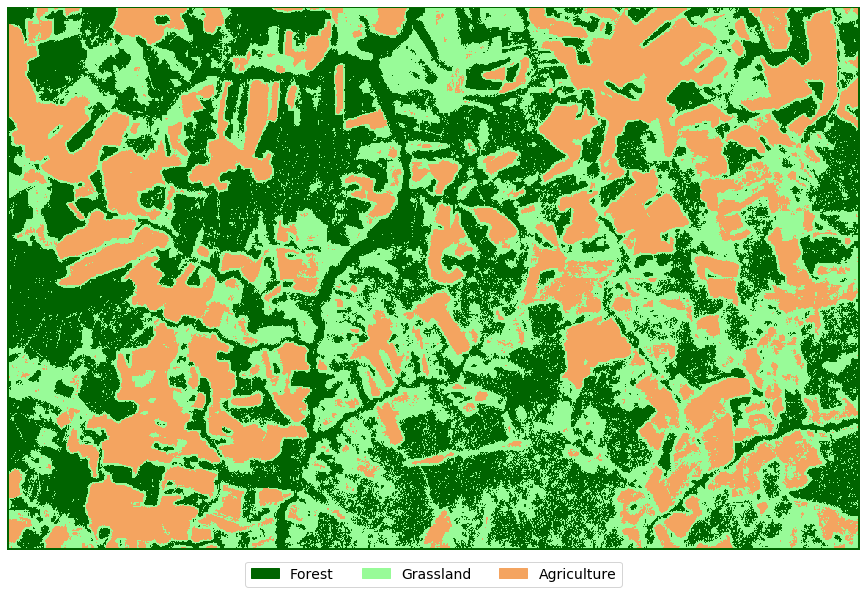

In [71]:
print("Generating and evaluating the MLP classification model...")
mlp, confusion_pred_M_MLP_SL = MLP_model(X_train, Y_train, X_test, Y_test, hidden_layer_sizes_=(n_hidden_layers), 
                                max_iter_=epochs, solver_='sgd', learning_rate_init_=0.01, momentum_=m, alpha_=a)

print("\nClassifying the entire dataset (temporal metrics) using the MLP model...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ---------------- ANACONDA crushed every time I tried to use the full array (pixels_metrics) ---------------
number_of_splits = 8
array = np.array_split(pixels_metrics, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    partial_pred = mlp.predict(arr)
    class_pred = np.concatenate((class_pred, partial_pred))

classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)
    
if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_M_MLP_SL)

# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset:")
confusion_pred_M_MLP_SL

#### MLP (Keras)

In [67]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_Metrics_MLP_Keras.csv"
filename_map = dir_output_metrics+filenames[channel]+"_Metrics_MLP_Keras.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_Metrics_MLP_KerasconfusionMatrix.csv"

In [56]:
MLP_keras, confusion_pred_M_MLP = model_MLP_keras(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, 
                                                  n_hidden_layers=n_hidden_layers, epochs=epochs, 
                                                  n_neurons_ouputLayer=n_classes, learning_rate=0.01, momentum=m, verbose=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               800       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 303       
Total params: 21,303
Trainable params: 21,303
Non-trainable params: 0
_________________________________________________________________
    Overall accuracy (resubst): 0.8786
    Overall accuracy (holdout): 0.8178



Classifying the entire dataset (temporal metrics) using the MLP model (Keras)...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0,137.0,24.0,0.0,NaN,NaN
1,18.0,106.0,12.0,NaN,NaN
2,1.0,27.0,125.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.878571,0.817778


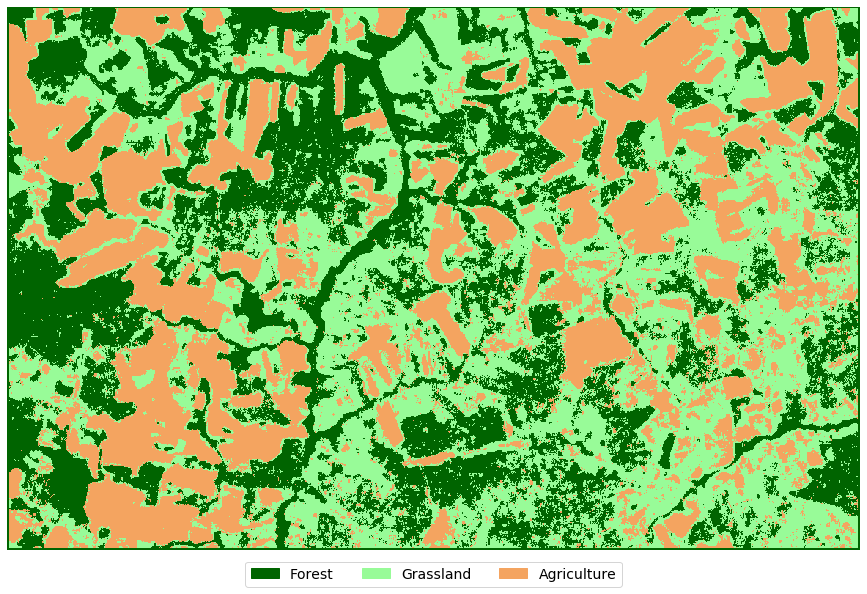

In [68]:
print("\nClassifying the entire dataset (temporal metrics) using the MLP model (Keras)...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

array = np.array_split(pixels_metrics, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    #arr_ = np.array(arr.copy()).reshape(arr.shape[0], 1, arr.shape[1])

    #partial_pred = lstm.predict_classes(arr_)
    partial_pred = MLP_keras.predict_classes(arr)
    class_pred = np.concatenate((class_pred, partial_pred))

classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_M_MLP)

# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_M_MLP

#### CNN

In [65]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_Metrics_CNN.csv"
filename_map = dir_output_metrics+filenames[channel]+"_Metrics_CNN.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_Metrics_CNNconfusionMatrix.csv"

In [58]:
cnn, confusion_pred_M_CNN = model_CNN(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, kernel_size=3, filters=31,
                                      neurons=100, n_neurons_ouputLayer=n_classes, verbose=False, epochs=epochs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 5, 31)             124       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 31)             2914      
_________________________________________________________________
flatten_1 (Flatten)          (None, 93)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               9400      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 303       
Total params: 12,741
Trainable params: 12,741
Non-trainable params: 0
_________________________________________________________________
    Overall accuracy (resubst): 0.875
    Overall accuracy (holdout): 0.8289



Classifying the entire dataset (temporal metrics) using the CNN model...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0,142.0,22.0,0.0,NaN,NaN
1,13.0,111.0,17.0,NaN,NaN
2,1.0,24.0,120.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.875,0.828889


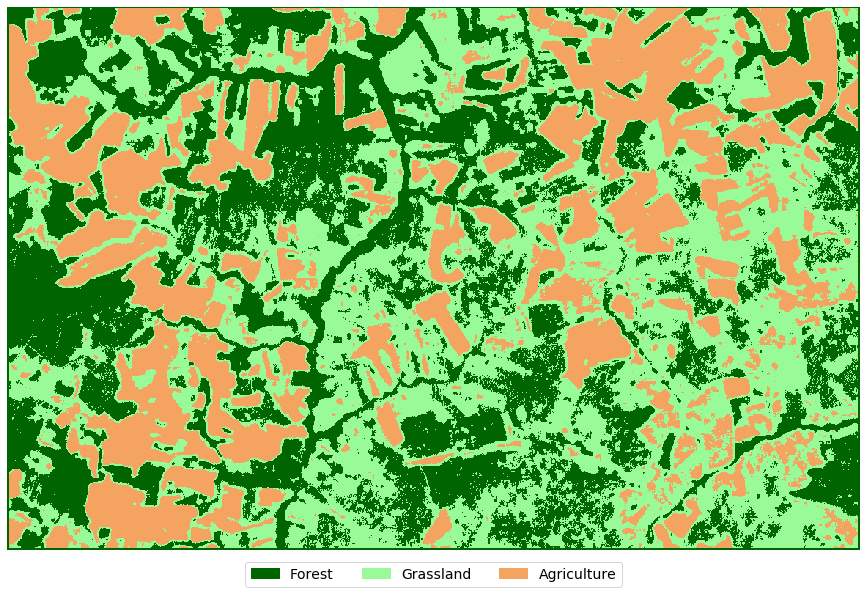

In [66]:
print("\nClassifying the entire dataset (temporal metrics) using the CNN model...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

array = np.array_split(pixels_metrics, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)

    arr_ = np.array(arr.copy()).reshape(arr.shape[0], arr.shape[1], 1)

    partial_pred = cnn.predict_classes(arr_)
    class_pred = np.concatenate((class_pred, partial_pred))
        
    
classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_M_CNN)

# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_M_CNN

#### LSTM

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://keras.io/getting-started/sequential-model-guide/#specifying-the-input-shape

In [59]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_Metrics_LSTM.csv"
filename_map = dir_output_metrics+filenames[channel]+"_Metrics_LSTM.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_Metrics_LSTMconfusionMatrix.csv"

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 100)            43200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 303       
Total params: 204,303
Trainable params: 204,303
Non-trainable params: 0
_________________________________________________________________


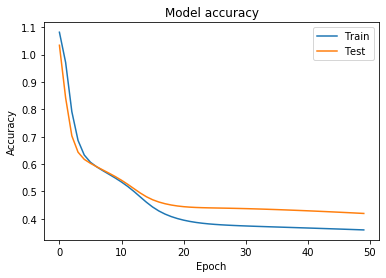

    Overall accuracy (resubst): 0.8714
    Overall accuracy (holdout): 0.8356


In [61]:
lstm, confusion_pred_M_lstm = LSTM_model(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, n_neurons=100, 
                                  n_neurons_ouputLayer=n_classes, training_epochs=epochs, 
                                  batch_size=124, verbose=False)


Classifying the entire dataset (temporal metrics) using the LSTM model...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0,140.0,18.0,0.0,NaN,NaN
1,16.0,120.0,21.0,NaN,NaN
2,0.0,19.0,116.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.871429,0.835556


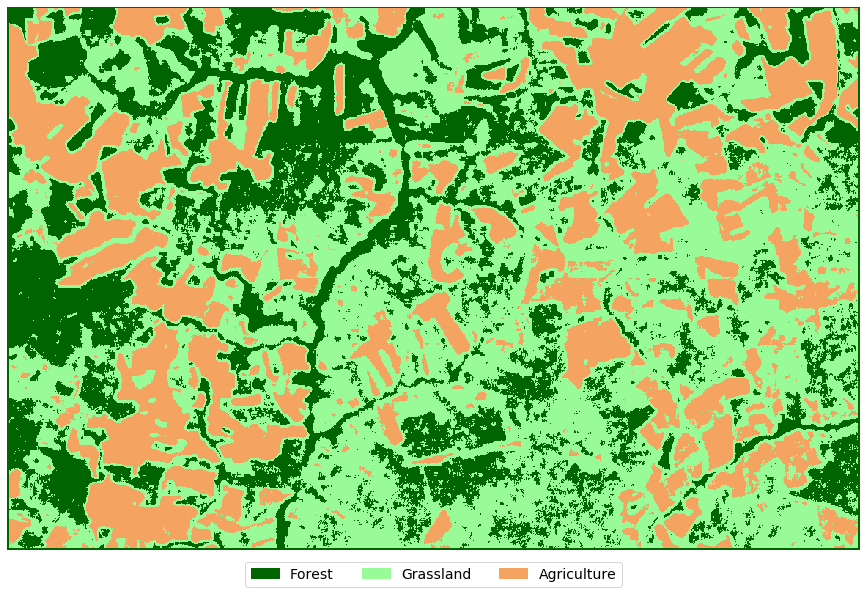

In [64]:
print("\nClassifying the entire dataset (temporal metrics) using the LSTM model...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

array = np.array_split(pixels_metrics, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    arr_ = np.array(arr.copy()).reshape(arr.shape[0], 1, arr.shape[1])
    
    #partial_pred = mlp.predict(arr)
    partial_pred = lstm.predict_classes(arr_)
    class_pred = np.concatenate((class_pred, partial_pred))

classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_M_lstm)
    
# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_M_lstm

***
### Classification of the original time series (without the extraction of temporal metrics)

In [31]:
pixel_TS = pd.read_csv(directories_pixel_TS[channel])
sample_TS = pd.read_csv(directories_sample_TS[channel])


sample_classes = sample_TS['class'].copy()
sample_TS.drop(labels='class', axis=1, inplace=True) # removing the column 'class' from the dataframe

smp_TS = np.float32(sample_TS)
smp_classes = np.float32(sample_classes)
smp_classes = np.ravel(smp_classes) # converting from column-vector to 1d array (expected by the classifier)
pixels_TS = np.float32(pixel_TS)

Preparation of the training, testing and validation datasets:

**Obs.:** 20% of the [initial] training dataset is used for validating the classification models.

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(smp_TS, smp_classes, test_size=test_size_)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2)

scaler = StandardScaler()
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
# apply same transformation to test and validation data
X_test = scaler.transform(X_test) 
X_valid = scaler.transform(X_valid) 

#### MLP (Scikit-Learn)

In [33]:
m = 0.8
a = 0
n_hidden_layers = 100
neurons = 100
epochs = 50

In [34]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_TS_MLP.csv"
filename_map = dir_output_metrics+filenames[channel]+"_TS_MLP.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_TS_MLPconfusionMatrix.csv"

Generating and evaluating the MLP classification model...


C:\Users\Willian\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


    Overall accuracy (resubst): 0.8881
    Overall accuracy (holdout): 0.84

Classifying the entire dataset (original TS) using the MLP model...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0.0,129.0,28.0,3.0,NaN,NaN
1.0,10.0,116.0,15.0,NaN,NaN
2.0,0.0,16.0,133.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.888095,0.84


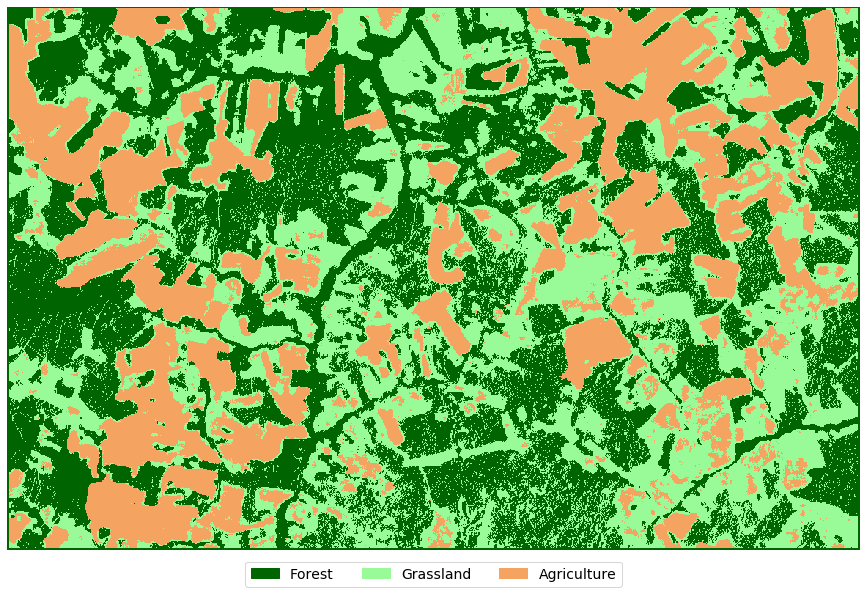

In [35]:
print("Generating and evaluating the MLP classification model...")
mlp, confusion_pred_MLP_SL = MLP_model(X_train, Y_train, X_test, Y_test, hidden_layer_sizes_=(n_hidden_layers), 
                                max_iter_=epochs, solver_='sgd', learning_rate_init_=0.01, momentum_=m, alpha_=a)

print("\nClassifying the entire dataset (original TS) using the MLP model...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

if(np.isnan(pixels_TS).any() == True): # If there is nan values, replace missing data with the mean
    # Create our imputer to replace missing values with the mean e.g.
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(pixels_TS)
    # Impute our data, then train
    pixels_TS = imp.transform(pixels_TS)

array = np.array_split(pixels_TS, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    partial_pred = mlp.predict(arr)
    class_pred = np.concatenate((class_pred, partial_pred))

classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)
    
if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_MLP_SL)

# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_MLP_SL

#### MLP (Keras)

In [36]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_TS_MLP_Keras.csv"
filename_map = dir_output_metrics+filenames[channel]+"_TS_MLP_Keras.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_TS_MLP_KerasconfusionMatrix.csv"

In [37]:
MLP_keras, confusion_pred_MLP = model_MLP_keras(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, 
                                                n_hidden_layers=n_hidden_layers, epochs=epochs, n_neurons_ouputLayer=n_classes, 
                                                learning_rate=0.01, momentum=m, verbose=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               3200      
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 303       
Total params: 23,703
Trainable params: 23,703
Non-trainable params: 0
_________________________________________________________________
    Overall accuracy (resubst): 0.9929
    Overall accuracy (holdout): 0.8578



Classifying the entire dataset (original TS) using the MLP model (Keras)...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0,119.0,16.0,2.0,NaN,NaN
1,19.0,129.0,11.0,NaN,NaN
2,1.0,15.0,138.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.992857,0.857778


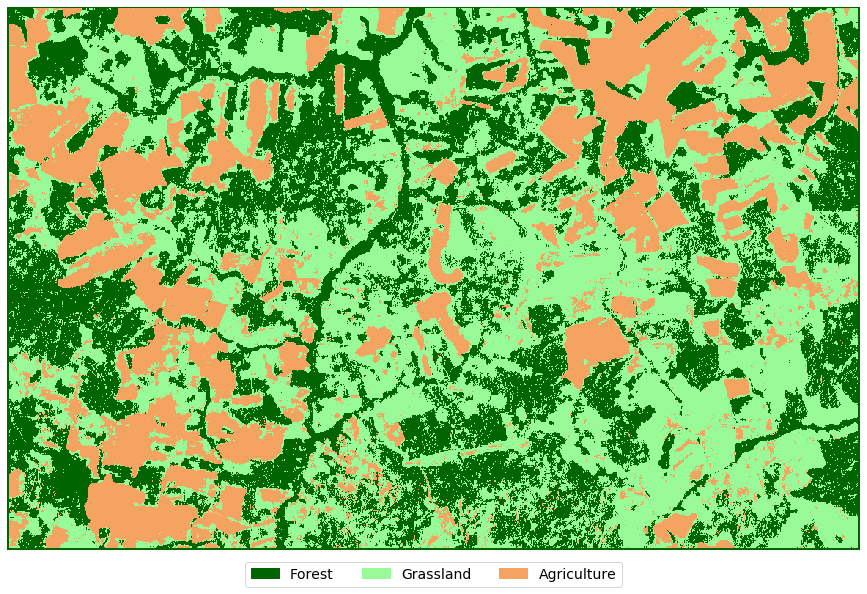

In [38]:
print("\nClassifying the entire dataset (original TS) using the MLP model (Keras)...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

if(np.isnan(pixels_TS).any() == True): # If there is nan values, replace missing data with the mean
    # Create our imputer to replace missing values with the mean e.g.
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(pixels_TS)
    # Impute our data, then train
    pixels_TS = imp.transform(pixels_TS)

array = np.array_split(pixels_TS, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    #arr_ = np.array(arr.copy()).reshape(arr.shape[0], 1, arr.shape[1])

    #partial_pred = lstm.predict_classes(arr_)
    partial_pred = MLP_keras.predict_classes(arr)
    class_pred = np.concatenate((class_pred, partial_pred))

classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_MLP)
    
# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_MLP

#### CNN

https://datascience.stackexchange.com/questions/38957/keras-conv1d-for-simple-data-target-prediction

https://keras.io/examples/imdb_cnn_lstm/

In [39]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_TS_CNN.csv"
filename_map = dir_output_metrics+filenames[channel]+"_TS_CNN.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_TS_CNNconfusionMatrix.csv"

In [40]:
cnn, confusion_pred_CNN = model_CNN(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, kernel_size=3, filters=31, 
                                    neurons=neurons, n_neurons_ouputLayer=n_classes, verbose=False, epochs=epochs)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 29, 31)            124       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 27, 31)            2914      
_________________________________________________________________
flatten_2 (Flatten)          (None, 837)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               83800     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 303       
Total params: 87,141
Trainable params: 87,141
Non-trainable params: 0
_________________________________________________________________
    Overall accuracy (resubst): 0.9214
    Overall accuracy (holdout): 0.8644



Classifying the entire dataset (original TS) using the CNN model...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0,120.0,15.0,3.0,NaN,NaN
1,17.0,136.0,15.0,NaN,NaN
2,2.0,9.0,133.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.921429,0.864444


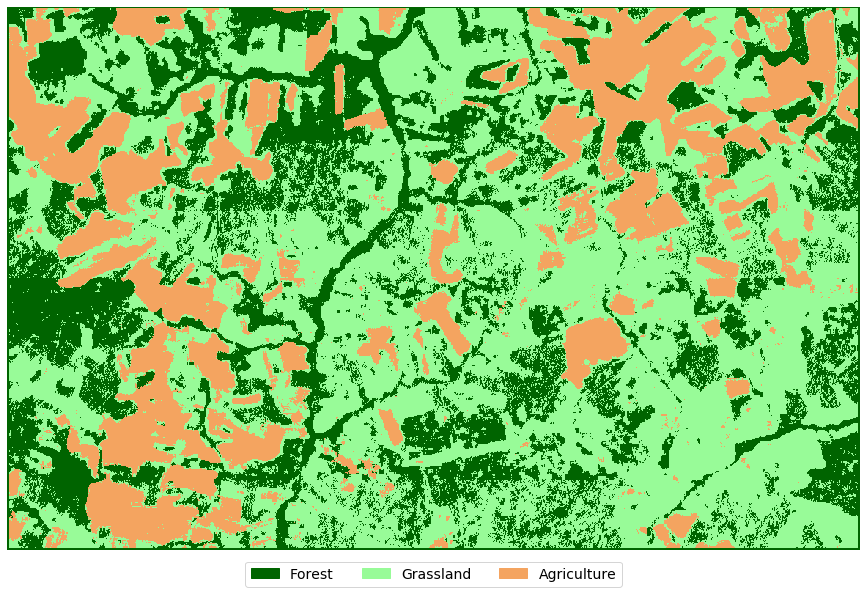

In [41]:
print("\nClassifying the entire dataset (original TS) using the CNN model...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

if(np.isnan(pixels_TS).any() == True): # If there is nan values, replace missing data with the mean
    # Create our imputer to replace missing values with the mean e.g.
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(pixels_TS)
    # Impute our data, then train
    pixels_TS = imp.transform(pixels_TS)

array = np.array_split(pixels_TS, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)

    arr_ = np.array(arr.copy()).reshape(arr.shape[0], arr.shape[1], 1)

    partial_pred = cnn.predict_classes(arr_)
    class_pred = np.concatenate((class_pred, partial_pred))
        
    
classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_CNN)
    
# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_CNN

#### LSTM

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://keras.io/getting-started/sequential-model-guide/#specifying-the-input-shape

In [51]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_TS_LSTM.csv"
filename_map = dir_output_metrics+filenames[channel]+"_TS_LSTM.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_TS_LSTMconfusionMatrix.csv"

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 100)            52800     
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 303       
Total params: 213,903
Trainable params: 213,903
Non-trainable params: 0
_________________________________________________________________


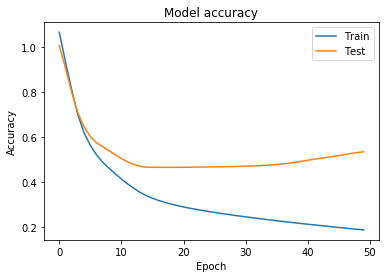

    Overall accuracy (resubst): 0.9369
    Overall accuracy (holdout): 0.8667


In [52]:
lstm, confusion_pred_LSTM = LSTM_model(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, n_neurons=neurons, 
                                  n_neurons_ouputLayer=n_classes, training_epochs=epochs, 
                                  batch_size=124, verbose=False)


Classifying the entire dataset (original TS) using the LSTM model...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0,125.0,21.0,1.0,NaN,NaN
1,12.0,128.0,13.0,NaN,NaN
2,2.0,11.0,137.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.936905,0.866667


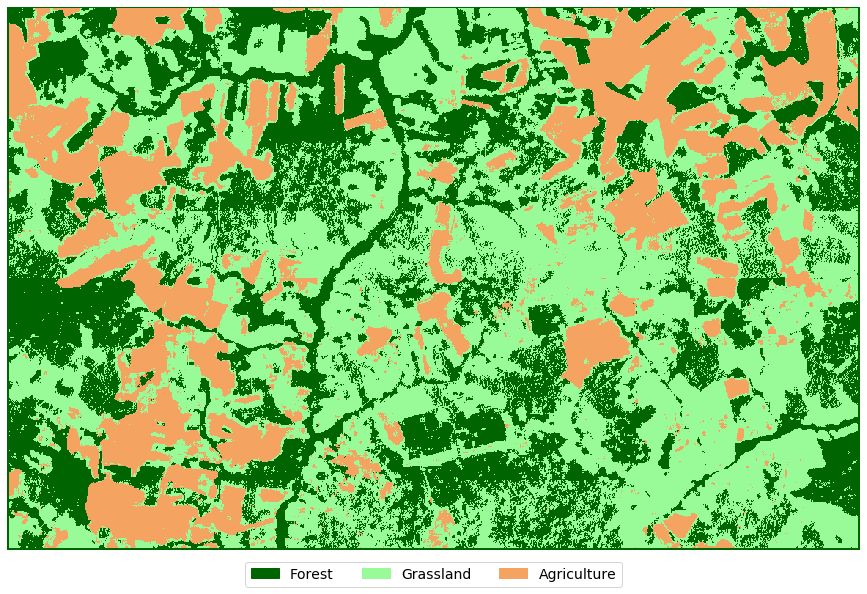

In [53]:
print("\nClassifying the entire dataset (original TS) using the LSTM model...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

if(np.isnan(pixels_TS).any() == True): # If there is nan values, replace missing data with the mean
    # Create our imputer to replace missing values with the mean e.g.
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(pixels_TS)
    # Impute our data, then train
    pixels_TS = imp.transform(pixels_TS)

array = np.array_split(pixels_TS, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    arr_ = np.array(arr.copy()).reshape(arr.shape[0], 1, arr.shape[1])
    
    #partial_pred = mlp.predict(arr)
    partial_pred = lstm.predict_classes(arr_)
    class_pred = np.concatenate((class_pred, partial_pred))

classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_LSTM)
    
# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_LSTM

***

### LSTM and MLP ensemble

Olhar:

https://datascience.stackexchange.com/questions/26103/merging-two-different-models-in-keras

https://stackoverflow.com/questions/52232665/how-to-merge-multiple-sequential-models-in-keras-python

https://datascience.stackexchange.com/questions/13428/what-is-the-significance-of-model-merging-in-keras

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

Ver funções create_mlp, create_cnn e a parte referente a 'create the MLP and CNN models
' em: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [54]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_TS_LSTM_MLP.csv"
filename_map = dir_output_metrics+filenames[channel]+"_TS_LSTM_MLP.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_TS_LSTM_MLPconfusionMatrix.csv"

In [55]:
lstm_mlp, confusion_pred_LSTM_MLP = model_LSTM_MLP(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, lstm, MLP_keras, 
                                          n_classes=n_classes, verbose=False, neurons=neurons, epochs=epochs)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_7_input (InputLayer)       (None, 1, 31)        0                                            
__________________________________________________________________________________________________
dense_11_input (InputLayer)     (None, 31)           0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 1, 100)       52800       lstm_7_input[0][0]               
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 100)          3200        dense_11_input[0][0]             
____________________________________________________________________________________________


Classifying the entire dataset (original TS) using the ensemble of the LSTM and MLP models...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0,122.0,19.0,3.0,NaN,NaN
1,15.0,129.0,11.0,NaN,NaN
2,2.0,12.0,137.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.996429,0.862222


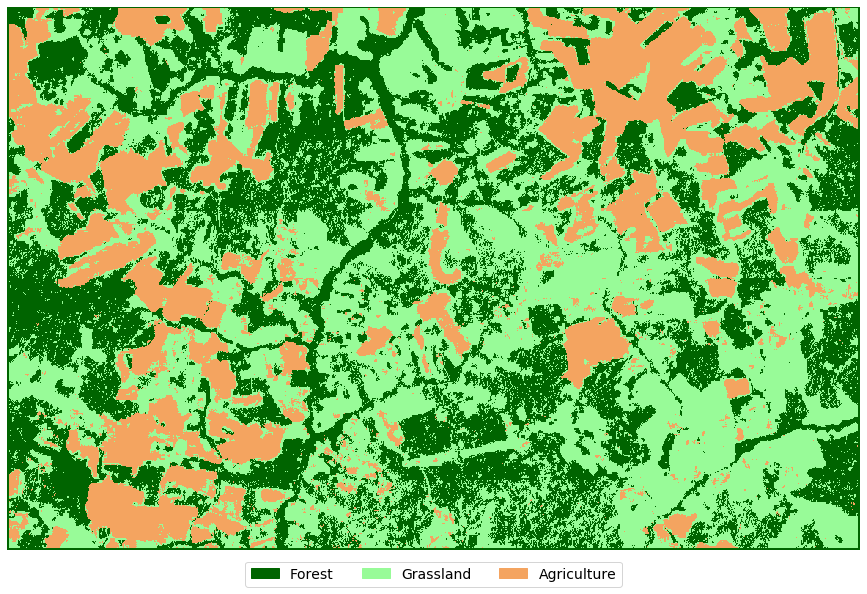

In [56]:
print("\nClassifying the entire dataset (original TS) using the ensemble of the LSTM and MLP models...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

if(np.isnan(pixels_TS).any() == True): # If there is nan values, replace missing data with the mean
    # Create our imputer to replace missing values with the mean e.g.
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(pixels_TS)
    # Impute our data, then train
    pixels_TS = imp.transform(pixels_TS)

array = np.array_split(pixels_TS, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    arr_ = np.array(arr.copy()).reshape(arr.shape[0], 1, arr.shape[1])

    partial_pred = lstm_mlp.predict([arr_, arr])
    partial_pred = np.argmax(partial_pred, axis=1)  
    class_pred = np.concatenate((class_pred, partial_pred))
        
    
classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_LSTM_MLP)

# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_LSTM_MLP

***

### LSTM and CNN ENSEMBLE

In [57]:
# Names for the output files
filename_array = dir_output_metrics+filenames[channel]+"_TS_LSTM_CNN.csv"
filename_map = dir_output_metrics+filenames[channel]+"_TS_LSTM_CNN.tif"
filename_matrix = dir_output_metrics+filenames[channel]+"_TS_LSTM_CNNconfusionMatrix.csv"

In [58]:
lstm_cnn, confusion_pred_LSTM_CNN = model_LSTM_CNN(X_train, X_test, X_valid, Y_train, Y_test, Y_valid, lstm, cnn, 
                                                   n_classes=n_classes, verbose=False, epochs=epochs, neurons=neurons)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_3_input (InputLayer)     (None, 31, 1)        0                                            
__________________________________________________________________________________________________
lstm_7_input (InputLayer)       (None, 1, 31)        0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 29, 31)       124         conv1d_3_input[0][0]             
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 1, 100)       52800       lstm_7_input[0][0]               
____________________________________________________________________________________________


Classifying the entire dataset (original TS) using the ensemble of the LSTM and CNN models...

Writing results to files...
    The products were written to file!

Confusion matrix computed using the testing dataset: 


Actual,0.0,1.0,2.0,OA_Resubs,OA_Holdout
Pred,,,,,
0,125.0,17.0,2.0,NaN,NaN
1,12.0,126.0,13.0,NaN,NaN
2,2.0,17.0,136.0,NaN,NaN
Accuracies,NaN,NaN,NaN,0.979762,0.86


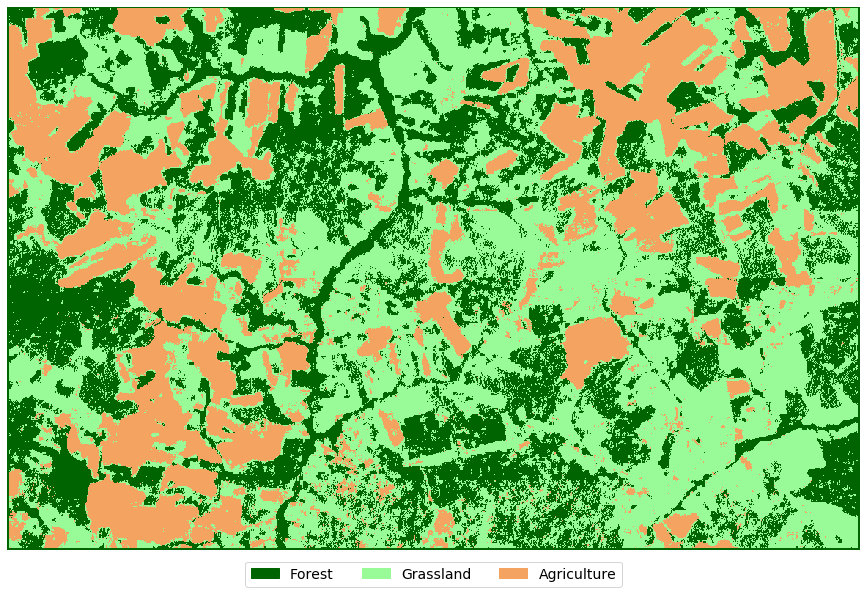

In [59]:
print("\nClassifying the entire dataset (original TS) using the ensemble of the LSTM and CNN models...")
# ----------------------------------- PARTIAL CLASSIFICATION OF ALL PIXELS ----------------------------------
# ------------------- ANACONDA crushed every time I tried to use the full array (pixels_TS) -----------------
number_of_splits = 8

if(np.isnan(pixels_TS).any() == True): # If there is nan values, replace missing data with the mean
    # Create our imputer to replace missing values with the mean e.g.
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(pixels_TS)
    # Impute our data, then train
    pixels_TS = imp.transform(pixels_TS)

array = np.array_split(pixels_TS, indices_or_sections=number_of_splits)
class_pred = []

scaler = StandardScaler()
for arr in array:
    scaler.fit(arr)  
    arr = scaler.transform(arr)
    
    arr_ = np.array(arr.copy()).reshape(arr.shape[0], 1, arr.shape[1])
    arr_cnn = np.array(arr.copy()).reshape(arr.shape[0], arr.shape[1], 1)

    partial_pred = lstm_cnn.predict([arr_, arr_cnn])
    partial_pred = np.argmax(partial_pred, axis=1)  
    class_pred = np.concatenate((class_pred, partial_pred))
        
    
classification_matrix, Nrows, Ncols, GeoTransform, Projection = predictionArray_to_matrix(imgPath, class_pred)

if (write_files == 'YES'):
    print("\nWriting results to files...")
    export_classification_files(classification_matrix, Nrows, Ncols, GeoTransform, Projection, 
                                filename_array, filename_map, filename_matrix, confusion_pred_LSTM_CNN)

# Show classification map
show_classification_map(classification_matrix, labels, colours)

# Confusion matrix (test samples)
print("\nConfusion matrix computed using the testing dataset: ")
confusion_pred_LSTM_CNN